## Notebook to calculate votes creation trends for tag

### Description
This notebook calculate basic trends data like tag rank based on the number of up-votes up until certain date.

### Input
This notebook takes as an input `posts_tag.csv` and `votes.csv` file, produced by the previous step.

### Output
As an output this notebook produces `votes_trends.csv` file with the following format:
```
Tag,CreationDate,TagPostsCreated,TagTotalPostsCreated,PostsCreated,TotalPostsCreated,TagPostsShare,TagRank
{tag},{creation-date},{tag-posts-created},{tag-total-posts-created},{posts-created},{tag-posts-share},{tag-rank}
```

where:
- `{tag}` - single tag related to a post. For instance: `c#`
- `{creation-date}` - post creation in 'YYYY-MM' format. For example: '2008-07'
- `{tag-votes-created}` - the number of posts created with that tag and at `{creation-date}`;
- `{tag-total-votes-created}` - the cumulative number of votes created with that tag from the beginning up until `{creation-date}`;
- `{votes-created}` - the number of all votes created at `{creation-date}`;
- `{total-votes-created}` - the cumulative number of posts created from the beginning up until `{creation-date}`;
- `{tag-posts-share}` - the percentage of posts created with that tag comparing to all posts. Calculated as `{tag-total-votes-created} / {total-votes-created} * 100`;
- `{tag-rank}` - the rank of the `{tag}` based on `{tag-votes-share}` in comparison to other tags at the same `{creation-date}`;

For example:
```csv
Tag,CreationDate,TagPostsCreated,TagTotalPostsCreated,PostsCreated,TotalPostsCreated,TagPostsShare,TagRank
```

In [1]:
import pandas as pd
from config import get_file_path

#### Load data, show shape and sample

In [2]:
votes_file_path = get_file_path("votes.csv")
votes_df = pd.read_csv(votes_file_path)
votes_df

,PostId,VoteTypeId,CreationDate
0,1,2,2008-07-31T00:00:00.000
1,3,2,2008-07-31T00:00:00.000
2,2,2,2008-07-31T00:00:00.000
3,4,2,2008-07-31T00:00:00.000
4,6,2,2008-07-31T00:00:00.000
...,...,...,...
111853481,8586244,2,2017-02-13T00:00:00.000
111853482,33701823,2,2017-02-13T00:00:00.000
111853483,42071132,2,2017-02-13T00:00:00.000
111853484,42071132,1,2017-02-13T00:00:00.000


In [4]:
votes_df['CreationDate'] = pd.to_datetime(votes_df['CreationDate'])
agg_votes_df = votes_df.groupby('PostId')['CreationDate'].agg(['min', 'max'])
agg_votes_df['duration_days'] = (agg_votes_df['max'] - agg_votes_df['min']).dt.days
average_duration = agg_votes_df['duration_days'].mean()
print("Average duration in days:", average_duration)

Average duration in days: 239.62430287077828


In [6]:
std_deviation_duration_days = agg_votes_df['duration_days'].std()
print("Standard deviation of duration days:", std_deviation_duration_days)

Standard deviation of duration days: 526.0368007046947


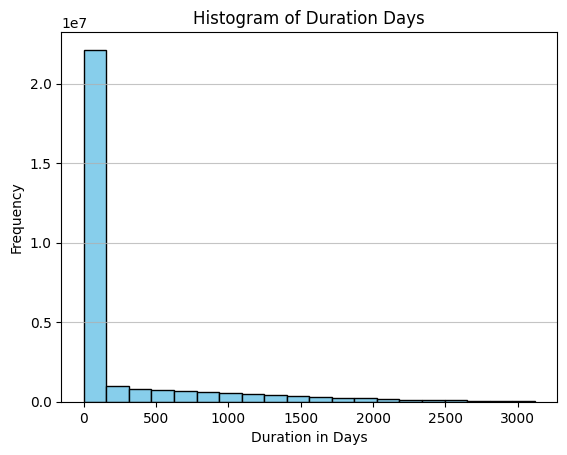

In [5]:
import matplotlib.pyplot as plt

# Plot histogram of 'duration_days' directly using pandas
agg_votes_df['duration_days'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')

plt.title('Histogram of Duration Days')
plt.xlabel('Duration in Days')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Display the plot
plt.show()

In [4]:
### Filter data

In [5]:
up_votes_df = votes_df[votes_df['VoteTypeId'] == 2]
up_votes_count = len(up_votes_df)
votes_count = len(votes_df) 
up_votes_percentage = round(up_votes_count / votes_count * 100)
print(f'The number of up votes is {up_votes_count}, which is {up_votes_percentage}% of all votes.')

The number of up votes is 84732023, which is 76% of all votes.


### Convert create date-time to year month format

In [6]:
up_votes_year_month_df = up_votes_df.copy()
up_votes_year_month_df['CreationDateNew'] = pd.to_datetime(up_votes_df['CreationDate']).dt.strftime('%Y-%m')
up_votes_df = up_votes_year_month_df.drop(['CreationDate'], axis=1).rename(columns={'CreationDateNew': 'CreationDate'})
up_votes_df

,PostId,VoteTypeId,CreationDate
0,1,2,2008-07
1,3,2,2008-07
2,2,2,2008-07
3,4,2,2008-07
4,6,2,2008-07
...,...,...,...
111853480,12158933,2,2017-02
111853481,8586244,2,2017-02
111853482,33701823,2,2017-02
111853483,42071132,2,2017-02


In [7]:
### Assossiate with tags

In [8]:
posts_tag_file_path = get_file_path("posts_tag.csv")
posts_tag_df = pd.read_csv(posts_tag_file_path)
posts_tag_df

,Id,CreationDate,Tag
0,4,2008-07,c#
1,4,2008-07,floating-point
2,4,2008-07,type-conversion
3,4,2008-07,double
4,4,2008-07,decimal
...,...,...,...
168684444,78091263,2024-03,react-hooks
168684445,78091263,2024-03,setstate
168684446,78091259,2024-03,drupal
168684447,78091259,2024-03,drupal-9


In [9]:
vote_tag_df = pd.merge(
    posts_tag_df,
    up_votes_df,
    left_on='Id',
    right_on='PostId',
    how='inner',
    suffixes=('_Post', '_Vote')
)[['Tag', 'CreationDate_Vote']].\
rename(columns={'CreationDate_Vote': 'CreationDate'})

vote_tag_df

,Tag,CreationDate
0,c#,2008-07
1,c#,2008-08
2,c#,2008-08
3,c#,2008-08
4,c#,2008-08
...,...,...
228891540,deleted-functions,2017-01
228891541,deleted-functions,2017-01
228891542,deleted-functions,2017-01
228891543,regex,2015-10


### Calculate the number of votes per tag and creation date.

In [12]:
tag_votes_created_df = vote_tag_df.groupby(['Tag', 'CreationDate'], as_index=False).\
    size().\
    rename(columns={'size': 'TagVotesCreated'}).\
    sort_values(by=['Tag', 'CreationDate'])
tag_votes_created_df

,Tag,CreationDate,TagVotesCreated
0,.a,2010-01,6
1,.a,2010-04,6
2,.a,2010-06,1
3,.a,2010-12,1
4,.a,2011-01,2
...,...,...,...
2027154,zypper,2016-09,3
2027155,zypper,2016-10,2
2027156,zypper,2016-11,2
2027157,zypper,2016-12,3


### Calculate the cumulative number of posts per tag and creation date.

In [15]:
tag_total_votes_created_sequence = tag_votes_created_df.groupby('Tag')['TagVotesCreated']. \
    expanding(). \
    sum(). \
    reset_index(level=0, drop=True)

tag_total_votes_created_df = tag_votes_created_df.copy()
tag_total_votes_created_df = tag_total_votes_created_df.assign(TagTotalVotesCreated=tag_total_votes_created_sequence)
tag_total_votes_created_df

,Tag,CreationDate,TagVotesCreated,TagTotalVotesCreated
0,.a,2010-01,6,6.0
1,.a,2010-04,6,12.0
2,.a,2010-06,1,13.0
3,.a,2010-12,1,14.0
4,.a,2011-01,2,16.0
...,...,...,...,...
2027154,zypper,2016-09,3,33.0
2027155,zypper,2016-10,2,35.0
2027156,zypper,2016-11,2,37.0
2027157,zypper,2016-12,3,40.0


### Calculate the number of votes per creation date.

In [17]:
votes_created_df = vote_tag_df.\
    groupby(['CreationDate'], as_index=False).\
    size().\
    rename(columns={'size': 'VotesCreated'}).\
    sort_values(by=['CreationDate'])
votes_created_df

,CreationDate,VotesCreated
0,2008-07,13
1,2008-08,63458
2,2008-09,299171
3,2008-10,345612
4,2008-11,246888
...,...,...
99,2016-10,3844663
100,2016-11,3886380
101,2016-12,3634526
102,2017-01,4063821


In [ ]:
votes_df['Score']